Машинное обучение, осень 2016. Никита Волков

Learning to rank with scikit-learn: the pairwise transform
============================================================
На основе https://github.com/fabianp/minirank/blob/master/notebooks/pairwise_transform.ipynb


<img width=300 src="./priestor34.jpg">

In [1]:
import itertools
import numpy as np
from scipy import stats, linalg
from sklearn import svm, linear_model, cross_validation

import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('text', usetex=True)
plt.rc('text.latex', unicode=True)
plt.rc('text.latex', preamble='\\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble='\\usepackage[russian]{babel}')
plt.rc('font', family='serif', size='16')

Сгенерируем датасет из 60 объектов с двумя признаками, для которого оценка релевантности принимает три различных значения --- 0, 1 и 2.
Датасет имеет два различных запроса, по каждому из которых есть 30 потенциально релеватных документа.
На графике точки, соответствующие парам запрос-документ для первого запроса изображены круглыми точкам, для второго --- треугольными.

/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


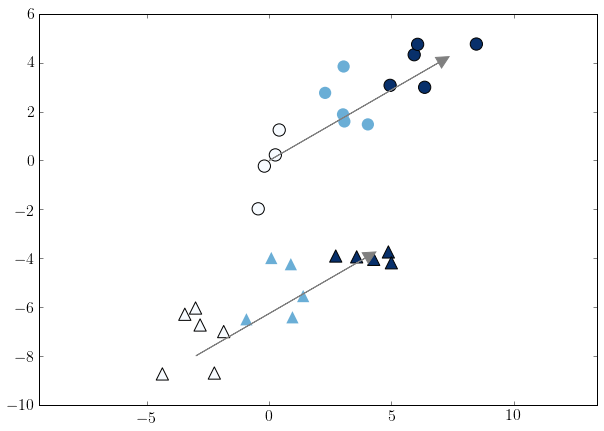

In [2]:
np.random.seed(21)
theta = np.deg2rad(60)
w = np.array([np.sin(theta), np.cos(theta)])
K = 20
X = np.random.randn(K, 2)
y = [0] * K
for i in range(1, 3):
    X = np.concatenate((X, np.random.randn(K, 2) + i * 4 * w))
    y = np.concatenate((y, [i] * K))

# slightly displace data corresponding to our second partition
X[::2] -= np.array([3, 7]) 
blocks = np.array([0, 1] * int(X.shape[0] / 2))

# split into train and test set
cv = cross_validation.StratifiedShuffleSplit(y, test_size=.5, n_iter=1)
train, test = next(iter(cv))
X_train, y_train, b_train = X[train], y[train], blocks[train]
X_test, y_test, b_test = X[test], y[test], blocks[test]

# plot the result
idx = (b_train == 0)
plt.figure(figsize=(10, 7))
plt.scatter(X_train[idx, 0], X_train[idx, 1], c=y_train[idx], marker='^', 
            cmap=plt.cm.Blues, s=150, lw=(1 - y_train[idx]))
plt.scatter(X_train[~idx, 0], X_train[~idx, 1], c=y_train[~idx], marker='o', 
            cmap=plt.cm.Blues, s=150, lw=(1 - y_train[~idx]))
plt.arrow(0, 0, 8 * w[0], 8 * w[1], fc='gray', ec='gray', 
          head_width=0.5, head_length=0.5)
plt.arrow(-3, -8, 8 * w[0], 8 * w[1], fc='gray', ec='gray', 
          head_width=0.5, head_length=0.5)
plt.axis('equal')
plt.show()

На графике четко видно, что для обоих запросов есть общий вектор $w$, такой что проекция на него дает правильное ранжирование.
Однако, линейные модели считают, что все объекты лежат в некотором метрическом пространстве.
Таким образом, при рассмотрении таких моделей мы будем получать результат явно не оптимальный.

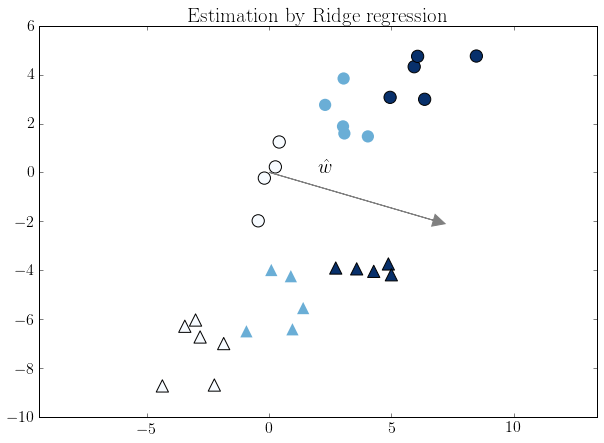

In [3]:
ridge = linear_model.Ridge(1.)
ridge.fit(X_train, y_train)
coef = ridge.coef_ / linalg.norm(ridge.coef_)

plt.figure(figsize=(10, 7))
plt.scatter(X_train[idx, 0], X_train[idx, 1], c=y_train[idx], marker='^', 
            cmap=plt.cm.Blues, s=150, lw=(1 - y_train[idx]))
plt.scatter(X_train[~idx, 0], X_train[~idx, 1], c=y_train[~idx], marker='o', 
            cmap=plt.cm.Blues, s=150, lw=(1 - y_train[~idx]))
plt.arrow(0, 0, 7 * coef[0], 7 * coef[1], fc='gray', ec='gray', 
          head_width=0.5, head_length=0.5)
plt.text(2, 0, '$\hat{w}$', fontsize=20)
plt.axis('equal')
plt.title('Estimation by Ridge regression')
plt.show()

Для оценки качества нашей модели мы должны определить некоторую метрику качества.
Поскольку нас интересует только то, как данная модель сортирует данные, естественно рассматривать метрику, которая сравнивает порядок, порождаемый моделью, с заданным порядком.
Давайте использовать для этого коэффициент корреляции Кенделла (http://en.wikipedia.org/wiki/Kendall_tau_rank_correlation_coefficient), который определяется как
$$\frac{P - Q}{P + Q},$$
где $P$ --- количество пар, для которых взаимный порядок совпадает (для двух заданных ранжирований), $Q$ --- количество пар, для которых он не совпадает.
Эта метрика широко используется в литературе по ранжированию (http://www.cs.cornell.edu/people/tj/publications/joachims_02c.pdf)

Применим эту метрику на тесте для каждого запроса отдельно.

In [4]:
for i in range(2):
    tau, _ = stats.kendalltau(ridge.predict(X_test[b_test == i]), y_test[b_test == i])
    print('Kendall correlation coefficient for query %s: %.3f' % (i, tau))

Kendall correlation coefficient for query 0: 0.845
Kendall correlation coefficient for query 1: 0.822


The pairwise transform
----------------------

Как показано в (http://www.mendeley.com/research/support-vector-learning-ordinal-regression/), если мы будем рассматривать линейные функции для ранжирования, вместо задачи ранжирования можно рассматривать эквивалентную задачу двуклассовой классификации.
Для этого мы создадим разности всех сравнимых элементов, то есть наши данные будут преобразованы в $(X'_k, Y'_k) = (X_i - X_j, sign(Y_i - Y_j))$ для пар, для которых можно определить порядок.

Следующий график показывает этот преобразованный датасет, цвет точек отражает разницу в метках, и наша задача --- отделить положительные точки от отрицательных. Гиперплоскость $x^T w = 0$ разделяет эти классы.

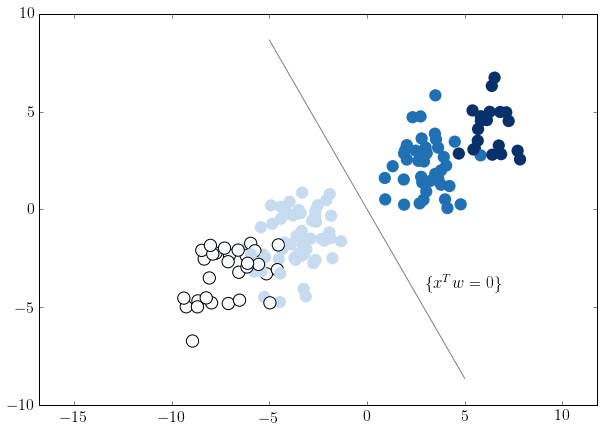

In [5]:
# form all pairwise combinations
comb = itertools.combinations(range(X_train.shape[0]), 2)
k = 0
Xp, yp, diff = [], [], []

for (i, j) in comb:
    if y_train[i] == y_train[j] \
        or blocks[train][i] != blocks[train][j]:
        # skip if same target or different group
        continue
        
    Xp.append(X_train[i] - X_train[j])
    diff.append(y_train[i] - y_train[j])
    yp.append(np.sign(diff[-1]))
    k += 1
    
Xp, yp, diff = map(np.asanyarray, (Xp, yp, diff))

plt.figure(figsize=(10, 7))
plt.scatter(Xp[:, 0], Xp[:, 1], c=diff, s=150, lw=(diff == -2), 
            marker='o', cmap=plt.cm.Blues)
x_space = np.linspace(-10, 10)
plt.plot(x_space * w[1], - x_space * w[0], color='gray')
plt.text(3, -4, '$\{x^T w = 0\}$', fontsize=17)
plt.axis('equal')
plt.show()

Как мы видим на предыдущем графике, классы разделимы.
Это не всегда будет так, но на нашей обучающей выборке нет инверсий порядка.

Теперь мы можем обучить SVM на преобразованных данных.
Эта модель называется RankSVM.
Далее приведен график обучающей выборки вместе с оцененным коэффициентом $\hat{w}$ с помощью RankSVM.

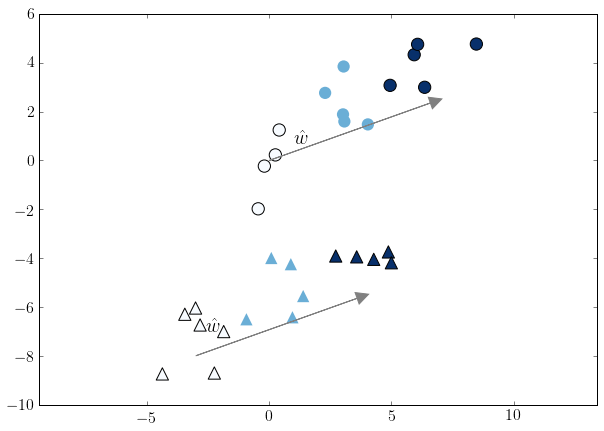

In [6]:
clf = svm.SVC(kernel='linear', C=.1)
clf.fit(Xp, yp)
coef = clf.coef_.ravel() / linalg.norm(clf.coef_)

plt.figure(figsize=(10, 7))
plt.scatter(X_train[idx, 0], X_train[idx, 1], c=y_train[idx], 
            lw=(1 - y_train[idx]), marker='^', cmap=plt.cm.Blues, s=150)
plt.scatter(X_train[~idx, 0], X_train[~idx, 1], c=y_train[~idx], 
            lw=(1 - y_train[~idx]), marker='o', cmap=plt.cm.Blues, s=150)
plt.arrow(0, 0, 7 * coef[0], 7 * coef[1], fc='gray', ec='gray', 
          head_width=0.5, head_length=0.5)
plt.arrow(-3, -8, 7 * coef[0], 7 * coef[1], fc='gray', ec='gray', 
          head_width=0.5, head_length=0.5)
plt.text(1, .7, '$\hat{w}$', fontsize=20)
plt.text(-2.6, -7, '$\hat{w}$', fontsize=20)
plt.axis('equal')
plt.show()

Наконец, убедимся, что коэффициент корреляции Кенделла увеличивается при использовании RankSVM вместо линейной регрессии.

In [7]:
for i in range(2):
    tau, _ = stats.kendalltau(
        np.dot(X_test[b_test == i], coef), y_test[b_test == i])
    print('Kendall correlation coefficient for query %s: %.3f' % (i, tau))

Kendall correlation coefficient for query 0: 0.845
Kendall correlation coefficient for query 1: 0.842


Эти значения действительно больше, чем значения (0.845, 0.822), полученные в случае линейной регрессии.

# RankLib (The Lemur Project)

<img src="./lemur-big-370.png">

RankLib --- мощная библиотека для обучения ранжированию. Написана на Java. Описание https://sourceforge.net/p/lemur/wiki/RankLib/

Возьмем датасет с конкурса «Интернет-математика 2009»
https://academy.yandex.ru/events/data_analysis/grant2009/

Ниже определены некоторые вспомогательные функции.

In [8]:
def read_file(file_path, features_count):
    ''' Считывает дата-файл по адресу file_path, в котором есть не более features_count признаков.
    Возвращает список меток релевантности, id запросов и матрицу признаков'''
    
    relevs = []
    qids = []
    features = []
    
    with open(file_path) as data_file:
        for line in data_file:
            split_line = line.split(' ')
            
            # релевантность и id запроса
            relevs.append(split_line[0])
            qids.append(int(split_line[1].split(':')[1]))
            
            # признаки
            object_features = np.zeros(features_count, dtype=float)
            for feat in split_line[2:]:
                index, value = map(float, feat.split(':'))
                object_features[index] = value
            
            features.append(object_features)
    
    return relevs, qids, np.array(features)


def write(features, relevs, qids, file_path, index_begin, index_end):
    ''' Создает файл по адресу file_path, в который будут записаны релевантности relevs,
    номера запросов qids и признаки features с номера index_begin по index_end. '''
    
    with open(file_path, 'w') as f:
        for index_line in range(index_begin, index_end):
            f.write('{} qid:{}'.format(relevs[index_line], qids[index_line]))
            for i in range(features.shape[1]):
                f.write(' {}:{}'.format(i + 1, features[index_line, i]))
            f.write('\n')
            

def split_to_train_valid_test(relevs, qids, features, 
                              train_path, test_path,
                              train_size, test_size,
                              valid_path=None, valid_size=None):
    ''' Разбивает датасет на две или три части, и записывает их в файлы'''

    num_docs = len(qids)
    i_0 = 0
    
    qids = np.array(qids)
    is_new_query = qids[:-1] != qids[1:]  # True в тех позициях, в которых начинается новый запрос
    new_query_positions = np.arange(num_docs - 1)[is_new_query]  # Позиции, в которых начинается новый запрос

    # Ищем позицию, на которой заканчивается train
    allow_positions = new_query_positions > (train_size * num_docs)
    i_1 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

    # Ищем позицию, на которой заканчивается test
    allow_positions = new_query_positions > ((train_size + test_size) * num_docs)
    i_2 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

    write(features, relevs, qids, train_path, i_0, i_1)
    write(features, relevs, qids, test_path, i_1, i_2)

    if valid_path is not None:
        # Ищем позицию, на которой заканчивается valid
        allow_positions = new_query_positions > ((train_size + test_size + valid_size) * num_docs)
        i_3 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

        write(features, relevs, qids, valid_path, i_2, i_3)

Загрузим датасет

In [9]:
relevs, qids, features = read_file('./data/imat2009_learning.txt', 250)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Разобьем его на три части и запишем каждую в файл. Основная проблема --- для RankLib у объекта должны быть указаны все признаки, даже если они равны нулю. Поэтому приходится их искусственно дописывать.

In [10]:
split_to_train_valid_test(relevs, qids, features,
                          './data/train.txt', './data/test.txt', 0.01, 0.01, 
                          valid_path='./data/valid.txt', valid_size=0.01)

Запустим LambdaMART (бустинг на деревьях, модель 6) на 100 деревьях с 5 листами в каждом. Будем использовать метрику $NDCG_{10}$. Сохраняем саму модель в ./model/LambdaMART_100_5.txt, а вывод обучения в ./model/log_LambdaMART_100_5.txt

In [11]:
%%time
! java -jar RankLib-2.1-patched.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 6 -tree 100 -leaf 5 -metric2t NDCG@10 -save ./model/LambdaMART_100_5.txt > ./model/log_LambdaMART_100_5.txt

CPU times: user 74.4 ms, sys: 16 ms, total: 90.4 ms
Wall time: 8.55 s


1000 деревьев, 10 листев в каждом

In [12]:
%%time
! java -jar RankLib-2.1-patched.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 6 -metric2t NDCG@10 -save ./model/LambdaMART_1000_10.txt > ./model/log_LambdaMART_1000_10.txt

CPU times: user 225 ms, sys: 28.2 ms, total: 253 ms
Wall time: 27.8 s


Тоже самое, но без валидационной выборки. То есть он будет строить все 1000 деревьев

In [13]:
%%time
! java -jar RankLib-2.1-patched.jar -train ./data/train.txt -test ./data/test.txt -ranker 6 -metric2t NDCG@10 -save ./model/LambdaMART_1000_10_novalid.txt > ./model/log_LambdaMART_1000_10_novalid.txt

CPU times: user 755 ms, sys: 100 ms, total: 855 ms
Wall time: 1min 40s


Запустим RankNet (нейронная сеть) с различными параметрами

In [14]:
%%time
! java -jar RankLib-2.1-patched.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 1 -metric2t NDCG@10 -save ./model/RankNet.txt > ./model/log_RankNet.txt

CPU times: user 314 ms, sys: 16.6 ms, total: 330 ms
Wall time: 44.8 s


In [15]:
%%time
! java -jar RankLib-2.1-patched.jar -train ./data/train.txt -test ./data/test.txt -validate ./data/valid.txt -ranker 1 -layer 3 -node 30 -metric2t NDCG@10 -save ./model/RankNet_3_30.txt > ./model/log_RankNet_3_30.txt

CPU times: user 1.13 s, sys: 93 ms, total: 1.22 s
Wall time: 2min 46s
